In [1]:
try:
    with open('foofile') as f:
        print(f)
except:
    print('oops!')

oops!


In [2]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
from zipfile import ZipFile

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

Using TensorFlow backend.


# Data Preparation

### Download the [UC Merced Land Use dataset](http://vision.ucmerced.edu/datasets/landuse.html)

### Extract image files from the zipped archive, if necessary

In [3]:
with suppress(FileExistsError):
    os.mkdir('data')

source_dir = os.path.join('data', 'UCMerced_LandUse', 'Images')

# Download the zipped dataset from http://vision.ucmerced.edu/datasets/landuse.html 
if not os.path.isdir(source_dir):
    with ZipFile('UCMerced_LandUse.zip') as z:
        z.extractall(path='data')

In [4]:
# Set random seed for reproducibility
np.random.seed(8)

### Randomly assign each image to train, validate, or test folder, segregated by class name

In [5]:
"""
Create image directory hierarchy that looks like this:
./data/flow/
            train/
                  agriculture/
                  airplane/
                  ...
            validate/
                     agriculture/
                     airplane/
                     ...
            test/
                 agriculture/
                 airplane/
                 ...
"""

# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory
flow_base = os.path.join('data', 'flow')

# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)

            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
            
                filenames = filenames[count:]
    
    # Show future warnings during development
    warnings.resetwarnings()

### Calculate the training image means by channel

In [6]:
means = []
for root, _, filenames in os.walk(target_dirs['train']):
    for filename in filenames:
        filepath = os.path.join(root, filename)
        image = imread(filepath)
        means.append(np.mean(image, axis=(0, 1)))
channel_means = np.mean(means, axis=0)

# Get training set bottleneck features from pretrained CNN

In [7]:
def get_bottleneck_features(model, dataset, preproc_func, batch_size=64):
    """
    Get botteleneck features X and labels Y for the input dataset (train/validate/test)
    by predicting on the convolutional portion only of a pretrained model.
    
    Note: Saves features and labels to numpy files for future use when rerunning the code.
        
    Inputs:
        model: Pre-trained deep learning model, excluding fully-connected top model
               e.g. applications.VGG16(include_top=False, weights='imagenet')
        dataset = string label for dataset image directory ['train', 'validate', 'test']
        preproc_func: preprocessing function implied to each input sample
        batch_size: number of image samples per batch
    
    Return:
        Return bottleneck features as numpy.array
    """

    print(f'Generating "{dataset}" bottleneck predictions')
    X_filepath = os.path.join('data', 'bn_' + dataset + '_X.npy')
    y_filepath = os.path.join('data', 'bn_' + dataset + '_y.npy')

    # Check if data are available from disk.
    try:
        with open(X_filepath, 'rb') as f:
            X = np.load(f)
        with open(y_filepath, 'rb') as f:
            y = np.load(f)
            Y = to_categorical(y, num_classes=len(np.unique(y)))
    # Else, get the bottleneck features and labels
    except:
        image_data_gen = ImageDataGenerator(rescale=1/255.0, preprocessing_function=preproc_func)
        image_generator = image_data_gen.flow_from_directory(target_dirs[dataset],
                                                             batch_size=batch_size,
                                                             shuffle=False
                                                             )
        image_count = 0
        X_batches, Y_batches = [], []
        for X, Y in image_generator:
            X_batches.append(model.predict_on_batch(X))
            Y_batches.append(Y)
            image_count += X.shape[0]
            # Must interrupt image_generator
            if image_count >= image_generator.n:
                break

        X = np.concatenate(X_batches)
        with open(X_filepath, 'wb') as f:
            np.save(f, X) 
        Y = np.concatenate(Y_batches)
        y = np.nonzero(Y)[1]
        with open(y_filepath, 'wb') as f:
            np.save(f, y)
    
    print(f'   Features of shape {X.shape} extracted for model "{model.name}"')
    return X, Y

### Select a pre-trained model from the Keras.applications module; e.g. Xception, VGG16 ...

In [8]:
# Let's try the VGG16 model
pretrained_model = applications.VGG16(include_top=False, weights='imagenet')

### Extract bottleneck features for each dataset: train, validate, and test

In [9]:
num_classes = len(class_names)
X, Y = dict(), dict()
preprocess = lambda x: x - channel_means
for dataset in ['train', 'validate', 'test']:
    # Extract bottleneck features from pretrained model, predicting from "dataset" directory
    X[dataset], Y[dataset] = get_bottleneck_features(pretrained_model, dataset, preprocess)

Generating "train" bottleneck predictions
   Features of shape (1680, 8, 8, 512) extracted for model "vgg16"
Generating "validate" bottleneck predictions
   Features of shape (210, 8, 8, 512) extracted for model "vgg16"
Generating "test" bottleneck predictions
   Features of shape (210, 8, 8, 512) extracted for model "vgg16"


# Train a fully-connected model using bottleneck features

In [10]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [11]:
# Build, compile, and fit the model
model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['train'], Y['train'], batch_size=64, epochs=30,
                              verbose=2, validation_data=(X['validate'], Y['validate']))

Train on 1680 samples, validate on 210 samples
Epoch 1/30
3s - loss: 2.1157 - acc: 0.3702 - val_loss: 1.0923 - val_acc: 0.7810
Epoch 2/30
3s - loss: 0.9384 - acc: 0.7327 - val_loss: 0.6865 - val_acc: 0.8571
Epoch 3/30
3s - loss: 0.5886 - acc: 0.8452 - val_loss: 0.5643 - val_acc: 0.8667
Epoch 4/30
3s - loss: 0.4195 - acc: 0.8887 - val_loss: 0.4866 - val_acc: 0.8667
Epoch 5/30
4s - loss: 0.3053 - acc: 0.9339 - val_loss: 0.4761 - val_acc: 0.8810
Epoch 6/30
3s - loss: 0.2538 - acc: 0.9446 - val_loss: 0.4232 - val_acc: 0.8857
Epoch 7/30
3s - loss: 0.2013 - acc: 0.9571 - val_loss: 0.3916 - val_acc: 0.8905
Epoch 8/30
3s - loss: 0.1629 - acc: 0.9738 - val_loss: 0.3778 - val_acc: 0.9048
Epoch 9/30
4s - loss: 0.1206 - acc: 0.9881 - val_loss: 0.3642 - val_acc: 0.9000
Epoch 10/30
3s - loss: 0.1217 - acc: 0.9833 - val_loss: 0.3588 - val_acc: 0.8905
Epoch 11/30
4s - loss: 0.0922 - acc: 0.9923 - val_loss: 0.3410 - val_acc: 0.9048
Epoch 12/30
4s - loss: 0.0807 - acc: 0.9935 - val_loss: 0.3452 - val_ac

### Plot training loss vs. validation loss

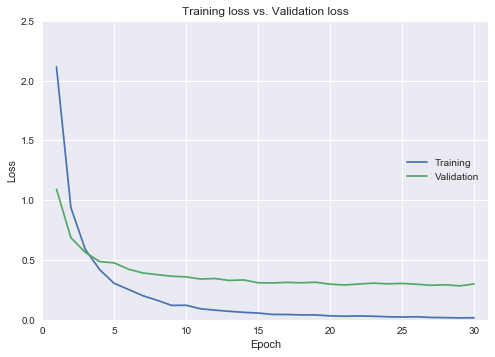

In [12]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['loss'])
max_loss = max(max(model_fit_history.history['loss']), max(model_fit_history.history['val_loss']))
plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['loss'])
plt.plot(x, model_fit_history.history['val_loss'])
plt.title('Training loss vs. Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

### Plot of training accuracy vs. validation accuracy

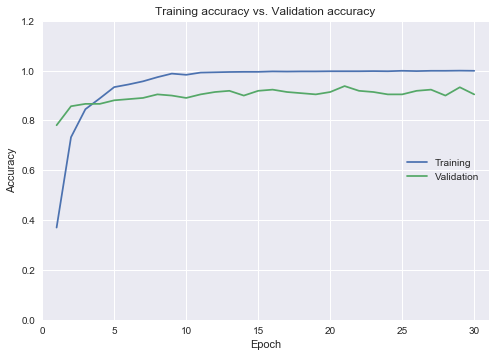

In [13]:
matplotlib.style.use('seaborn')
epochs = len(model_fit_history.history['acc'])
plt.axis([0, epochs+1, 0, 1.2])
x = np.arange(1, epochs+1)
plt.plot(x, model_fit_history.history['acc'])
plt.plot(x, model_fit_history.history['val_acc'])
plt.title('Training accuracy vs. Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.show()

<hr>

### To avoid overfitting, retrain the model through the epoch with smallest validation loss.

In [14]:
epochs = np.argmin(model_fit_history.history['val_loss']) + 1
print(f'Stop training at {epochs} epochs')

model = build_fully_connected(input_shape=X['train'].shape[1:], num_classes=num_classes)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model_fit_history = model.fit(X['train'], Y['train'], batch_size=64, epochs=epochs, verbose=0)

Stop training at 29 epochs


### Evaluate trained model on the test images

In [15]:
# Predict on the test images
y_pred = model.predict_classes(X['test'], verbose=0)

### Print classification results

In [16]:
# Flatten Y into a vector
y_test = np.nonzero(Y['test'])[1]
accuracy = accuracy_score(y_test, y_pred)
print(f'Model predication accuracy: {accuracy:.3f}')
print(f'\nClassification report:\n {classification_report(y_test, y_pred)}')

Model predication accuracy: 0.919

Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        10
          2       0.91      1.00      0.95        10
          3       1.00      0.90      0.95        10
          4       0.78      0.70      0.74        10
          5       1.00      1.00      1.00        10
          6       0.80      0.80      0.80        10
          7       0.91      1.00      0.95        10
          8       0.91      1.00      0.95        10
          9       0.83      1.00      0.91        10
         10       1.00      1.00      1.00        10
         11       0.77      1.00      0.87        10
         12       0.70      0.70      0.70        10
         13       0.91      1.00      0.95        10
         14       0.90      0.90      0.90        10
         15       1.00      1.00      1.00        10
         16       1.00      0.90      0

###  Test accuracy: 91.9%. Impressive for such a small image dataset.